## Feature transformations
Try adding feature transformations using a pipeline and a transformation, e.g. function transformer:
```python
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X, X**2], axis=1)),
    DecisionTreeClassifier()
)
```

Which transformations should improve the score?

Комментарий: конечно, добавлять квадраты в этом случае совсем глупо. Ведь условие $x_1^2 > α$ ничем не отличается от $x_1^2 > \sqrt{α}$. Это можно было даже заметить по тому, что получившиеся разделяющие прямые проходят точно вертикально или горизонтально, что не отличается от использования признаков $x_1$ и $x_2$.\
Можно заметить, что наши классы хорошо бы разделяли диагональные прямые. Добавим самые простые, имеющие 45 градусов с осями.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

In [12]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz

data = np.load('data.npz')
X, y = data["X"], data["y"]

--2021-12-20 23:32:10--  https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz
Распознаётся github.com (github.com)... 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 302 Found
Адрес: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz [переход]
--2021-12-20 23:32:10--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 108474 (106K) [application/octet-stream]
Сохранение в каталог: ««data.npz.4»».

data.npz.4          100%[===================>] 105,93K  --.-KB/s    за 0,07s   

2021-12-20 23:32:11 (1,53 MB/s) - «data.npz.4» сохра

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X,(X[:,0]+X[:,1])[:,None],(X[:,0]-X[:,1])[:,None]],axis = 1)),
    DecisionTreeClassifier(min_samples_leaf=10,max_depth=4)
)

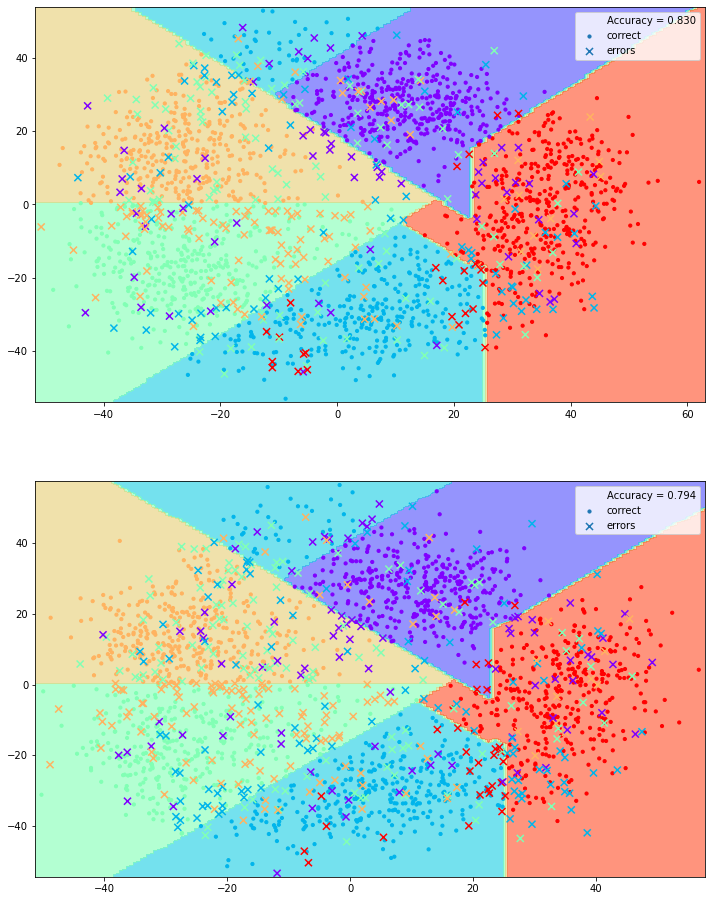

In [15]:
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');

По-моему, неплохо. Можно было бы попробовать поиграть с углом, добавить, скажем, прямые $x_2 = A + 2*x_1$, но идея в целом понятна.

# Classifying clothes

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.7.0


[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


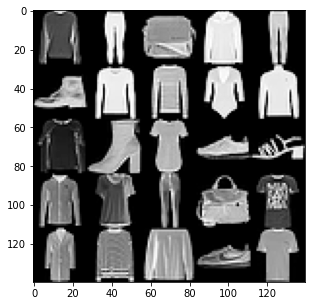

In [17]:
import tensorflow_datasets as tfds

data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

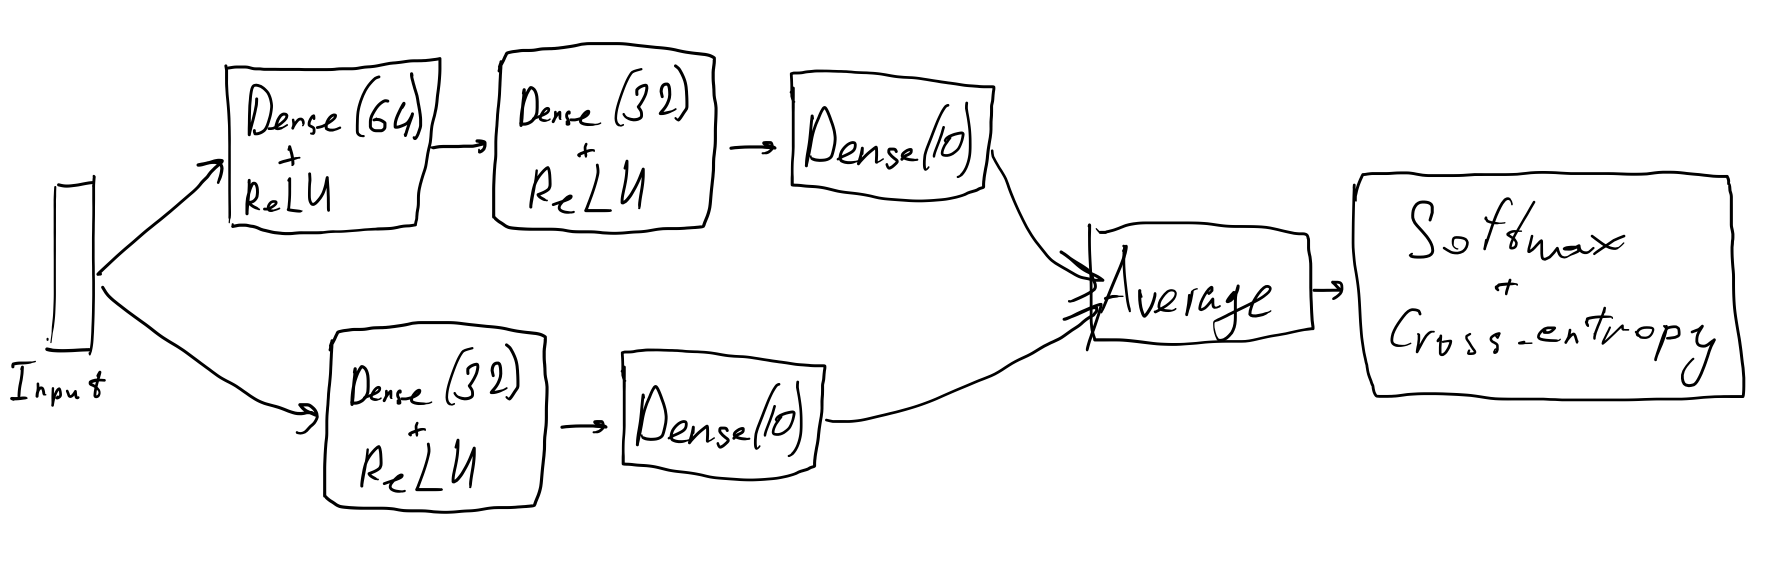

You can:
 - either use low-level API for that (still using `tf.keras.Sequential` models as building blocks)
 - or use `tf.keras.Model` for an arbitrary model (see examples from https://www.tensorflow.org/api_docs/python/tf/keras/Model)

Комментарий: убрал двойной softmax и лишний dense в конце. Плюс добавил функции активации dense-слоям на концах веток.

In [19]:
top_branch = tf.keras.Sequential([
    
    tf.keras.layers.Lambda(
      lambda x: tf.reshape(x / 255., (-1, 28*28)),
      input_shape=(28, 28, 1), name='preprocessing'
  ),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(10,activation = 'Дeaky relu')
])

down_branch = tf.keras.Sequential([
    
    tf.keras.layers.Lambda(
      lambda x: tf.reshape(x / 255., (-1, 28*28)),
      input_shape=(28, 28, 1), name='preprocessing'
  ),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(10,activation='sigmoid')
])


inputs = tf.keras.Input(shape=(28, 28, 1))
outputs = tf.keras.layers.Average()([top_branch(inputs),down_branch(inputs)])
model = tf.keras.Model(inputs, outputs)


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           52650       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           25450       ['input_1[0][0]']                
                                                                                                  
 average (Average)              (None, 10)           0           ['sequential[0][0]',             
                                                                  'sequential_1[0][0]']       

In [21]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics = 'accuracy')

In [22]:
def unwrap(x):
  return (x['image'], x['label'])

batch_size = 1024
model.fit(x=data_train.map(unwrap).shuffle(60000).batch(batch_size),
          epochs=10,
          validation_data=data_test.map(unwrap).batch(4096))

Epoch 1/10
59/59 [==============================] - 2s 14ms/step - loss: 1.2106 - accuracy: 0.6149 - val_loss: 0.7273 - val_accuracy: 0.7530
Epoch 2/10
59/59 [==============================] - 0s 7ms/step - loss: 0.6100 - accuracy: 0.7949 - val_loss: 0.5627 - val_accuracy: 0.8086
Epoch 3/10
59/59 [==============================] - 0s 7ms/step - loss: 0.5090 - accuracy: 0.8272 - val_loss: 0.5052 - val_accuracy: 0.8264
Epoch 4/10
59/59 [==============================] - 0s 7ms/step - loss: 0.4627 - accuracy: 0.8425 - val_loss: 0.4816 - val_accuracy: 0.8318
Epoch 5/10
59/59 [==============================] - 0s 7ms/step - loss: 0.4363 - accuracy: 0.8489 - val_loss: 0.4619 - val_accuracy: 0.8378
Epoch 6/10
59/59 [==============================] - 0s 7ms/step - loss: 0.4168 - accuracy: 0.8550 - val_loss: 0.4403 - val_accuracy: 0.8478
Epoch 7/10
59/59 [==============================] - 0s 7ms/step - loss: 0.4021 - accuracy: 0.8595 - val_loss: 0.4329 - val_accuracy: 0.8487
Epoch 8/10
59/59 [=